In [1]:
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np

# Entendendo os dados

In [2]:
data = pd.read_csv('SeoulBikeData.csv')

In [3]:
data.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


O data.info() nos mostra que não há entradas nulas, então não há necessecidade de tratar dados faltantes

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

Em baixo irei retirar os dias onde Functioning Day = No, ou seja os dias em que não houve funcionamento do aluguél de bikes

In [5]:
sum(data[data['Functioning Day'] == 'No']['Rented Bike Count'])

0

In [6]:
data = data[data['Functioning Day'] == 'Yes']

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8465 non-null   object 
 1   Rented Bike Count          8465 non-null   int64  
 2   Hour                       8465 non-null   int64  
 3   Temperature(°C)            8465 non-null   float64
 4   Humidity(%)                8465 non-null   int64  
 5   Wind speed (m/s)           8465 non-null   float64
 6   Visibility (10m)           8465 non-null   int64  
 7   Dew point temperature(°C)  8465 non-null   float64
 8   Solar Radiation (MJ/m2)    8465 non-null   float64
 9   Rainfall(mm)               8465 non-null   float64
 10  Snowfall (cm)              8465 non-null   float64
 11  Seasons                    8465 non-null   object 
 12  Holiday                    8465 non-null   object 
 13  Functioning Day            8465 non-null   objec

In [8]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

In [9]:
data['Month'] = pd.DatetimeIndex(data['Date']).month
data['Year'] = pd.DatetimeIndex(data['Date']).year
data['Day'] = pd.DatetimeIndex(data['Date']).day

# Análise dos dados

Os gráficos abaixo mostram que, os horários de maior procura estão bem definidos, e se mantem independente da estação. Até mesmo durante o inverno, onde há uma enorme redução dos alugueis, as 8 horas e as 18 horas continuam sendo os 2 principais horários de pico

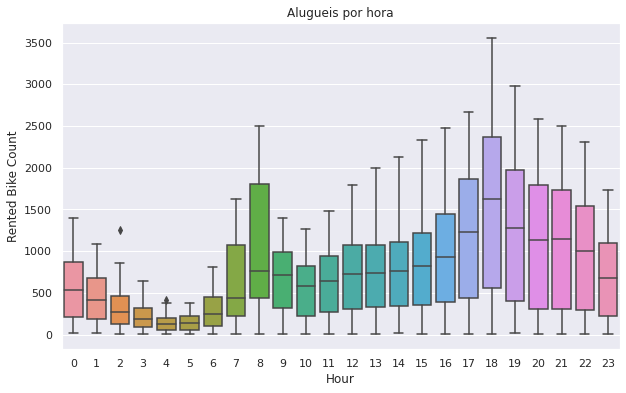

In [10]:
plt.figure(figsize=(10,6))
plt.title('Alugueis por hora')
sns.boxplot(y=data['Rented Bike Count'],x=data['Hour']);

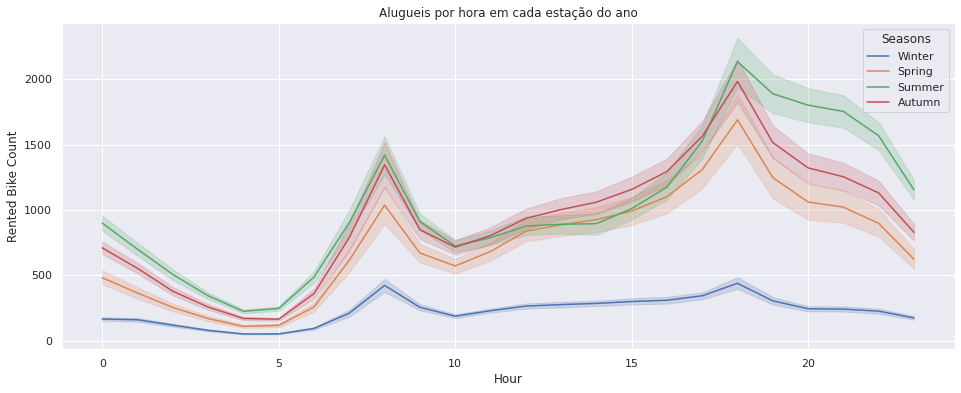

In [11]:
plt.figure(figsize=(16,6))
plt.title('Alugueis por hora em cada estação do ano')
sns.lineplot(y=data['Rented Bike Count'],x=data['Hour'], hue=data['Seasons']);

Os seguintes gráficos confirmam a baixa procura durante o inverno, além de uma procura quase igual durante primavera e outono e a superioridade do verão

Além disso, há uma procura maior durante dias convencionais, e os picos de 8 e 18 horas se mantem, no entanto em feriados não há um pico de procura durante as 8 e sim uma procura quase constante a partir das 10

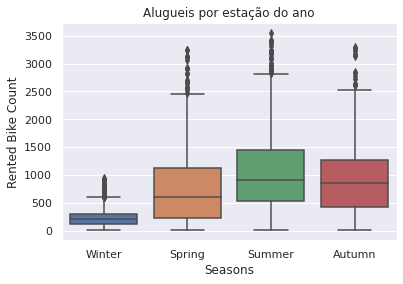

In [12]:
plt.title('Alugueis por estação do ano')
sns.boxplot(y=data['Rented Bike Count'],x=data['Seasons']);

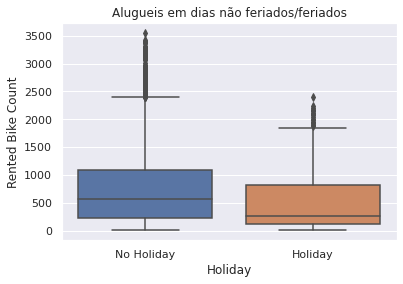

In [13]:
plt.title('Alugueis em dias não feriados/feriados')
sns.boxplot(y=data['Rented Bike Count'],x=data['Holiday']);

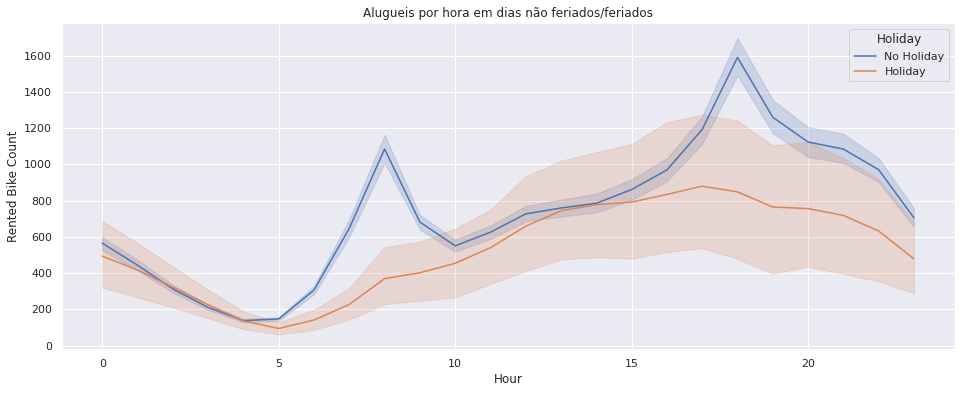

In [14]:
plt.figure(figsize=(16,6))
plt.title('Alugueis por hora em dias não feriados/feriados')
sns.lineplot(y=data['Rented Bike Count'],x=data['Hour'], hue=data['Holiday']);

Aqui vemos que as temperaturas durante a primavera e outono são bem próximas, o inverno é realmente frio e o verão realmente quente. E o gráfico de alugueis por temperatura reforça que, em dias mais quentes, há mais procura. O que não é nenhum absurdo visto que o verão é a estação de maior procura

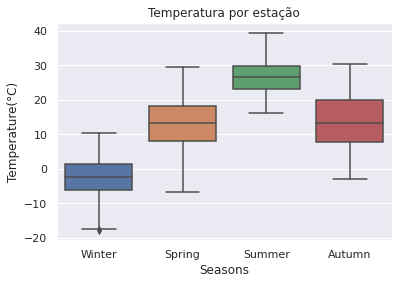

In [15]:
plt.title('Temperatura por estação')
sns.boxplot(y=data['Temperature(°C)'],x=data['Seasons']);

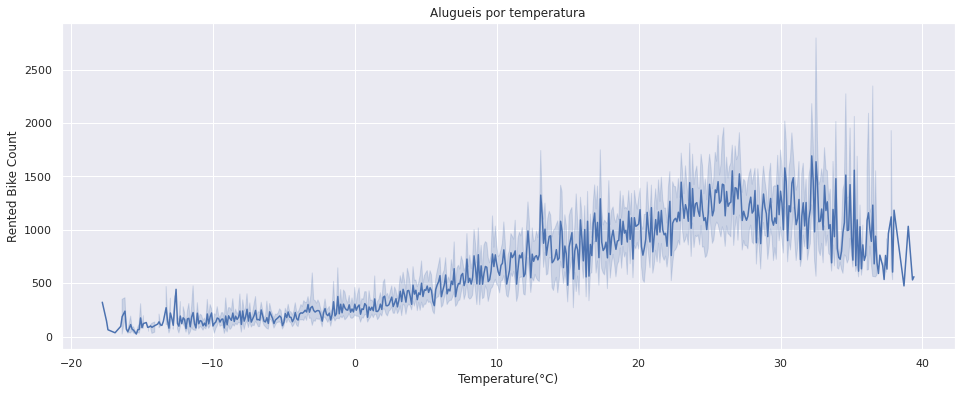

In [16]:
plt.figure(figsize=(16,6))
plt.title('Alugueis por temperatura')
sns.lineplot(y=data['Rented Bike Count'],x=data['Temperature(°C)']);

A seguir analiso a relação do aluguel com chuva, neve e humidade.

Dias com chuva implicam em uma menor procura

Dias com neve implicam em uma menor procura, algo que ja era esperado pois esse fenômeno ocorre durante o inverno

E humidades muito altas, ou muito baixa implicam em uma menor procura

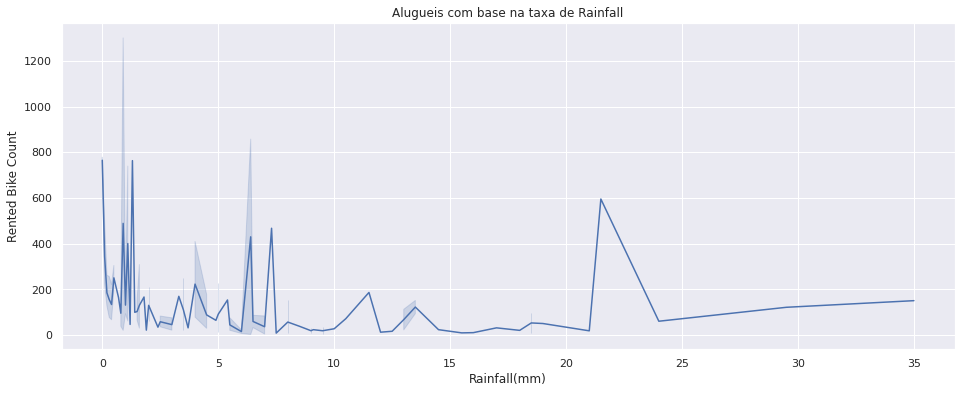

In [17]:
plt.figure(figsize=(16,6))
plt.title('Alugueis com base na taxa de Rainfall')
sns.lineplot(y=data['Rented Bike Count'],x=data['Rainfall(mm)']);

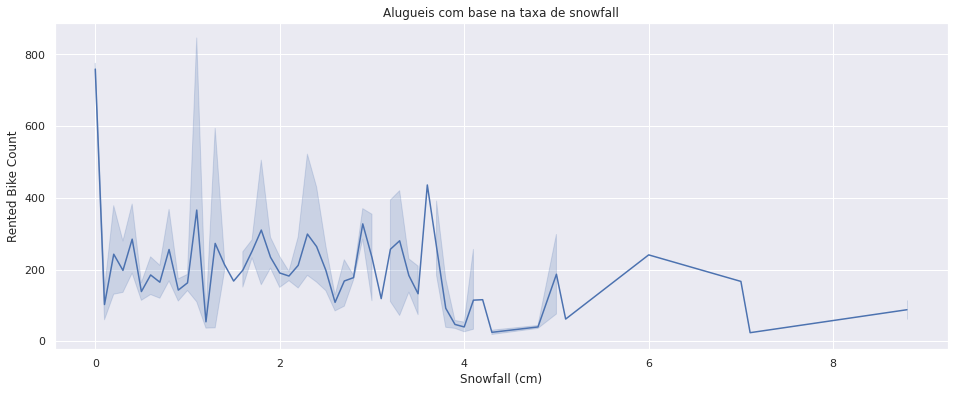

In [18]:
plt.figure(figsize=(16,6))
plt.title('Alugueis com base na taxa de snowfall')
sns.lineplot(y=data['Rented Bike Count'],x=data['Snowfall (cm)']);

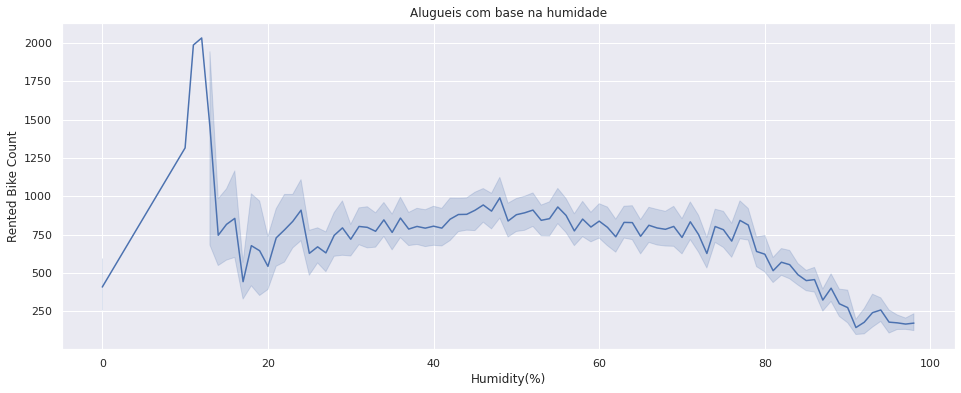

In [19]:
plt.figure(figsize=(16,6))
plt.title('Alugueis com base na humidade')
sns.lineplot(y=data['Rented Bike Count'],x=data['Humidity(%)']);

In [20]:
#Média de alugueis em dias chuvosos
aluguel_chuva =sum(data[data['Rainfall(mm)'] != 0]['Rented Bike Count'])/len(data[data['Rainfall(mm)'] != 0])
#Média de alugueis em dias sem chuva
aluguel = sum(data[data['Rainfall(mm)'] == 0]['Rented Bike Count'])/len(data[data['Rainfall(mm)'] == 0])

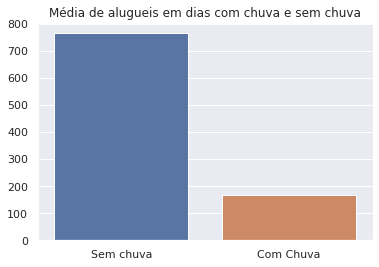

In [21]:
plt.title('Média de alugueis em dias com chuva e sem chuva')
sns.barplot(x=['Sem chuva', 'Com Chuva'],y=[aluguel,aluguel_chuva]);

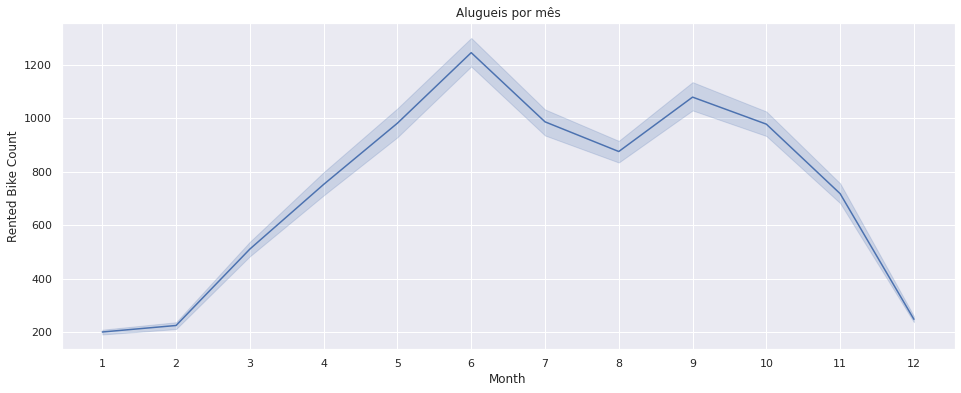

In [22]:
plt.figure(figsize=(16,6))
plt.title('Alugueis por mês')
ax = plt.gca()
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
sns.lineplot(y=data['Rented Bike Count'],x=data['Month']);

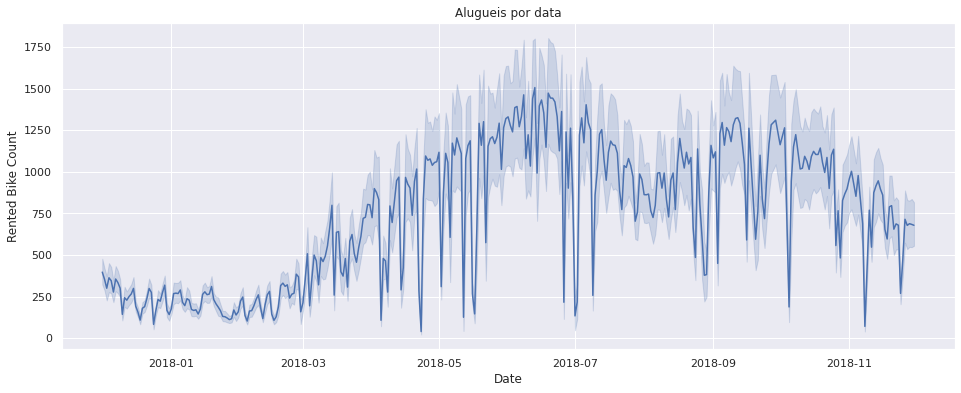

In [23]:
plt.figure(figsize=(16,6))
plt.title('Alugueis por data')
ax = plt.gca()
sns.lineplot(y=data['Rented Bike Count'],x=data['Date'], markers='OO');

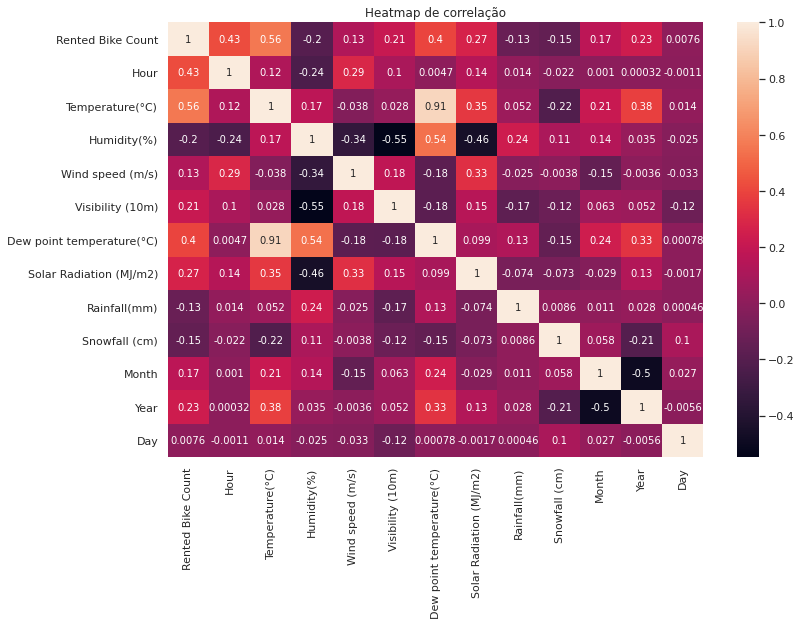

In [24]:
plt.figure(figsize=(12, 8))
plt.title('Heatmap de correlação')
sns.heatmap(data.corr(), annot=True);

Com essa análise podemos inferir que os principais fatores para os alugueis são a temperatura, a hora do dia, a humidade, o indicie de chuva e neve, além dos feriados. Tais coisas são muito bem representadas pelo mês como é possível ver no gráfico acima. Ao que tudo indica o mês 6 é o auge do verão em Seoul, e no mês 11 começa o inverno

Dew point temperature é um reflexo da temperatura, Solar Radiation também

As estações influenciam bastante, pois os dados climáticos são um reflexo disso.

# Preparações para o modelo preditivo 

In [25]:
def RMSLE(y_true, y_pred):
    """
        The Root Mean Squared Log Error (RMSLE) metric 
        
        :param y_true: The ground truth labels given in the dataset
        :param y_pred: Our predictions
        :return: The RMSLE score
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [26]:
data_cp = data.copy()

Crio e transformo os dados de estação e feriados de strings para inteiros, para serem utilizados no modelo

In [27]:
season_dummie = pd.get_dummies(data_cp['Seasons'])

In [28]:
data_cp = pd.concat([data_cp, season_dummie], axis=1)

In [29]:
data_cp['Holiday'] = pd.get_dummies(data_cp['Holiday'], drop_first=True)

In [30]:
data_cp.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),...,Seasons,Holiday,Functioning Day,Month,Year,Day,Autumn,Spring,Summer,Winter
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,...,Winter,1,Yes,12,2017,1,0,0,0,1
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,...,Winter,1,Yes,12,2017,1,0,0,0,1
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,...,Winter,1,Yes,12,2017,1,0,0,0,1
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,...,Winter,1,Yes,12,2017,1,0,0,0,1
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,...,Winter,1,Yes,12,2017,1,0,0,0,1


Agora separo o dataset em 4, cada um representando uma estação e removo os outliars de cada um e posteriormente junto eles novamente

In [31]:
X_ver = data_cp[data_cp['Summer'] == 1]
X_inv = data_cp[data_cp['Winter'] == 1]
X_pri = data_cp[data_cp['Spring'] == 1]
X_out = data_cp[data_cp['Autumn'] == 1]

In [32]:
def out_rem(dataset, column):
    """Remove dados acima do quantil 0.95 e abaixo do quantil 0.05 e retorna o novo dataset"""
    max_tresh = dataset[column].quantile(0.95)
    min_tresh = dataset[column].quantile(0.05)
    df = dataset[(dataset[column] < max_tresh) & (dataset[column] > min_tresh)]
    return df

In [33]:
print(X_ver.shape) #Antes da remoção

(2208, 21)


In [34]:
X_ver = out_rem(X_ver,'Rented Bike Count')
X_inv = out_rem(X_inv,'Rented Bike Count')
X_pri = out_rem(X_pri,'Rented Bike Count')
X_out = out_rem(X_out,'Rented Bike Count')

In [35]:
print(X_ver.shape) #Depois da remoção

(1986, 21)


In [36]:
data_clean = pd.concat([X_ver, X_inv, X_pri, X_out], axis=0) #Junto os 4 datasets limpos

O Boxplot abaixo, quando comparado com o primeiro feito lá em cima confirma que os outliars foram retirados

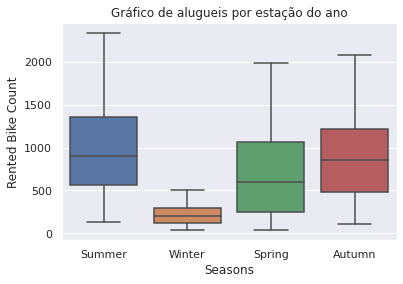

In [37]:
plt.title('Gráfico de alugueis por estação do ano')
sns.boxplot(y=data_clean['Rented Bike Count'],x=data_clean['Seasons']);

In [38]:
alugueis_por_dia = data_clean.groupby('Date').sum()['Rented Bike Count']
maximas = data_clean.groupby('Date')['Temperature(°C)'].max().rename('Temperatura Maxima')
minimas = data_clean.groupby('Date')['Temperature(°C)'].min().rename('Temperatura Minima')

In [39]:
data_final = data_clean.groupby('Date').mean().drop(['Rented Bike Count', 'Hour', 'Temperature(°C)','Day','Year','Winter','Month','Dew point temperature(°C)'], axis=1)

In [40]:
data_final = pd.concat([data_final, maximas, minimas], axis=1)

Para uma melhor utilização dos dados, vamos trabalhar com as vendas diárias e não por hora.
Utilizaremos as médias climáticas e as temperatúras máximas e mínimas de cada dia, pois utilizar o valor exato da hora exata tornaria o modelo pouco eficaz.

Vimos nos gráficos que as estações do ano tem forte influência no número de vendas, assim como a temperatura

In [41]:
data_final

,Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Autumn,Spring,Summer,Temperatura Maxima,Temperatura Minima
Date,,,,,,,,,,,,
2017-12-01,43.150000,1.555000,1844.900000,0.294000,0.000000,0.000000,1.0,0.0,0.0,0.0,3.0,-7.4
2017-12-02,67.157895,1.610526,1356.947368,0.168421,0.000000,0.000000,1.0,0.0,0.0,0.0,5.5,-4.4
2017-12-03,82.176471,1.600000,470.882353,0.090588,0.176471,0.000000,1.0,0.0,0.0,0.0,6.8,3.2
2017-12-04,55.631579,3.300000,1256.105263,0.335789,0.005263,0.000000,1.0,0.0,0.0,0.0,4.4,-5.8
2017-12-05,35.900000,1.250000,1951.350000,0.042500,0.000000,0.000000,1.0,0.0,0.0,0.0,-0.5,-7.6
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-26,69.521739,1.026087,484.130435,0.436957,0.000000,0.113043,1.0,1.0,0.0,0.0,13.2,1.7
2018-11-27,67.130435,1.365217,411.173913,0.200870,0.000000,0.000000,1.0,1.0,0.0,0.0,12.5,3.5
2018-11-28,25.791667,1.695833,1429.083333,0.403333,0.000000,0.000000,1.0,1.0,0.0,0.0,10.5,2.1


Escolhi dois modelos potentes de Regressão, RandomForestRegressor e XGBRegressor.

In [42]:
y_norm = np.log1p(alugueis_por_dia) #Escrevendo os valores como ln(1+x) para facilitar os cálculos

In [43]:
xgb = XGBRegressor(n_estimators=2100,learning_rate=0.03, n_jobs=4, random_state=19)

In [45]:
xgb_norm_pred = cross_val_predict(xgb,data_final, y_norm, cv=5)

In [46]:
#Valores escala log
print(np.mean(abs(xgb_norm_pred-y_norm)), ':Erro Absoluto')
print(np.mean(abs(xgb_norm_pred-y_norm)/y_norm),':Erro Relativo')
print(max(y_norm),max(xgb_norm_pred), ':Maximos normalizado,modelo')
print(min(y_norm),min(xgb_norm_pred), ':Mínimos normalizado,modelo')
print(RMSLE(y_norm,xgb_norm_pred), ':RMSLE')

0.2591102155141779 :Erro Absoluto
0.028443671256894874 :Erro Relativo
10.371927459805681 10.164264 :Maximos normalizado,modelo
6.698268054115413 7.549527 :Mínimos normalizado,modelo
0.03555947721110582 :RMSLE


In [47]:
#Valores reais
print(np.mean(abs(np.exp(xgb_norm_pred)-1-alugueis_por_dia)), ':Erro Absoluto')
print(np.mean(abs(np.exp(xgb_norm_pred)-1-alugueis_por_dia)/alugueis_por_dia),':Erro Relativo')
print(max(alugueis_por_dia),max(np.exp(xgb_norm_pred)-1), ':Maximos ,modelo')
print(min(alugueis_por_dia),min(np.exp(xgb_norm_pred)-1), ':Mínimos ,modelo')
print(RMSLE(alugueis_por_dia,np.exp(xgb_norm_pred)-1), ':RMSLE')

3073.3851899317237 :Erro Absoluto
0.2681740449664558 :Erro Relativo
31949 25957.742 :Maximos ,modelo
810 1898.8441 :Mínimos ,modelo
0.3522551527482774 :RMSLE


# Conclusão #

Dias de chuva, neve e feriados causam um impacto negativo nos alugueis.

O verão é a principal estação para o aluguel, e o inverno é a pior.

O principal horário de procura é as 18 horas, seguido das 8 e por final 17,19, que estão ao redor das 18, execeto no inverno, onde o horário de pico é as 8.

Utilizar o inverno, seguido dos feriados e dias chuvosos para realizar os principais reparos nas bicicletas seria uma boa estratégia para impedir que faltem bicicletas durante os outros períodos, e assim maximizar o lucro